In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


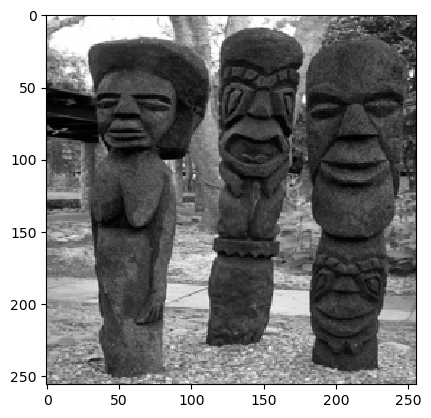

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    x=x0 #keeping var names constant
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserFinalWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

x0 = blurry_img + meas_sigma * torch.randn_like(blurry_img)
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)

  0%|          | 1/500 [00:00<02:01,  4.12it/s]

At iter 0, loss is: 18.403072357177734, PSNR of output is: 23.636324184447485, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:21, 23.05it/s]

At iter 10, loss is: 23.394855499267578, PSNR of output is: 23.20271114627407, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:17, 27.31it/s]

At iter 20, loss is: 23.39636993408203, PSNR of output is: 23.20248308637702, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:01<00:14, 31.66it/s]

At iter 30, loss is: 23.39636993408203, PSNR of output is: 23.20248151897492, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:01<00:13, 33.64it/s]

At iter 40, loss is: 23.39636993408203, PSNR of output is: 23.202481509246663, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:12, 34.98it/s]

At iter 50, loss is: 23.396371841430664, PSNR of output is: 23.202481526793513, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:12, 35.87it/s]

At iter 60, loss is: 23.396371841430664, PSNR of output is: 23.202481524695138, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:02<00:11, 37.07it/s]

At iter 70, loss is: 23.396371841430664, PSNR of output is: 23.20248150529271, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:02<00:11, 37.14it/s]

At iter 80, loss is: 23.396371841430664, PSNR of output is: 23.20248152398912, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:10, 37.33it/s]

At iter 90, loss is: 23.396371841430664, PSNR of output is: 23.202481507791703, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:10, 37.39it/s]

At iter 100, loss is: 23.396371841430664, PSNR of output is: 23.202481532572698, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:03<00:10, 37.64it/s]

At iter 110, loss is: 23.396371841430664, PSNR of output is: 23.20248152469159, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:03<00:09, 38.10it/s]

At iter 120, loss is: 23.396371841430664, PSNR of output is: 23.202481513851467, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:03<00:09, 37.89it/s]

At iter 130, loss is: 23.396371841430664, PSNR of output is: 23.202481528983544, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:04<00:09, 37.84it/s]

At iter 140, loss is: 23.396371841430664, PSNR of output is: 23.20248151934677, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:04<00:09, 38.43it/s]

At iter 150, loss is: 23.396371841430664, PSNR of output is: 23.20248151540533, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:04<00:08, 38.11it/s]

At iter 160, loss is: 23.396371841430664, PSNR of output is: 23.202481514550406, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:04<00:08, 37.94it/s]

At iter 170, loss is: 23.39636993408203, PSNR of output is: 23.202481518303678, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:05<00:08, 37.84it/s]

At iter 180, loss is: 23.396371841430664, PSNR of output is: 23.202481518314286, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:05<00:08, 37.79it/s]

At iter 190, loss is: 23.396371841430664, PSNR of output is: 23.20248152299838, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:05<00:07, 38.36it/s]

At iter 200, loss is: 23.39636993408203, PSNR of output is: 23.202481518118596, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:05<00:07, 38.14it/s]

At iter 210, loss is: 23.396371841430664, PSNR of output is: 23.20248149805005, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:06<00:07, 37.88it/s]

At iter 220, loss is: 23.396371841430664, PSNR of output is: 23.202481523475807, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:06<00:07, 37.66it/s]

At iter 230, loss is: 23.396371841430664, PSNR of output is: 23.202481507982256, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:06<00:06, 37.75it/s]

At iter 240, loss is: 23.396371841430664, PSNR of output is: 23.20248152187487, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:06<00:06, 38.40it/s]

At iter 250, loss is: 23.396371841430664, PSNR of output is: 23.202481534869133, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:07<00:06, 38.17it/s]

At iter 260, loss is: 23.396371841430664, PSNR of output is: 23.202481511992083, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:07<00:06, 37.84it/s]

At iter 270, loss is: 23.396371841430664, PSNR of output is: 23.2024815231026, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:07<00:05, 37.80it/s]

At iter 280, loss is: 23.396371841430664, PSNR of output is: 23.202481522679477, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:07<00:05, 37.70it/s]

At iter 290, loss is: 23.396371841430664, PSNR of output is: 23.202481526351416, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:08<00:05, 37.65it/s]

At iter 300, loss is: 23.396371841430664, PSNR of output is: 23.202481517451687, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:08<00:05, 37.77it/s]

At iter 310, loss is: 23.396371841430664, PSNR of output is: 23.202481519631743, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:08<00:04, 37.78it/s]

At iter 320, loss is: 23.396371841430664, PSNR of output is: 23.2024815072257, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:09<00:04, 38.16it/s]

At iter 330, loss is: 23.396371841430664, PSNR of output is: 23.2024815127787, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:09<00:04, 37.94it/s]

At iter 340, loss is: 23.396371841430664, PSNR of output is: 23.202481501175644, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:09<00:03, 37.83it/s]

At iter 350, loss is: 23.396371841430664, PSNR of output is: 23.202481522407904, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:09<00:03, 37.80it/s]

At iter 360, loss is: 23.39636993408203, PSNR of output is: 23.20248153727129, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:10<00:03, 37.65it/s]

At iter 370, loss is: 23.39636993408203, PSNR of output is: 23.202481514933663, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:10<00:03, 37.69it/s]

At iter 380, loss is: 23.396371841430664, PSNR of output is: 23.202481522859905, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:10<00:02, 38.29it/s]

At iter 390, loss is: 23.396371841430664, PSNR of output is: 23.202481506469987, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:10<00:02, 37.95it/s]

At iter 400, loss is: 23.396371841430664, PSNR of output is: 23.202481519467362, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:11<00:02, 37.85it/s]

At iter 410, loss is: 23.396371841430664, PSNR of output is: 23.20248151833723, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:11<00:02, 37.79it/s]

At iter 420, loss is: 23.396371841430664, PSNR of output is: 23.202481513283082, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:11<00:01, 37.74it/s]

At iter 430, loss is: 23.396371841430664, PSNR of output is: 23.20248151861117, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:11<00:01, 37.70it/s]

At iter 440, loss is: 23.39636993408203, PSNR of output is: 23.202481509279433, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:12<00:01, 37.64it/s]

At iter 450, loss is: 23.396371841430664, PSNR of output is: 23.202481521068247, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:12<00:01, 37.62it/s]

At iter 460, loss is: 23.39636993408203, PSNR of output is: 23.202481525986354, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:12<00:00, 37.66it/s]

At iter 470, loss is: 23.396371841430664, PSNR of output is: 23.202481529100787, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:12<00:00, 38.23it/s]

At iter 480, loss is: 23.396371841430664, PSNR of output is: 23.202481515826143, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:13<00:00, 37.69it/s]

At iter 490, loss is: 23.396371841430664, PSNR of output is: 23.202481522185145, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

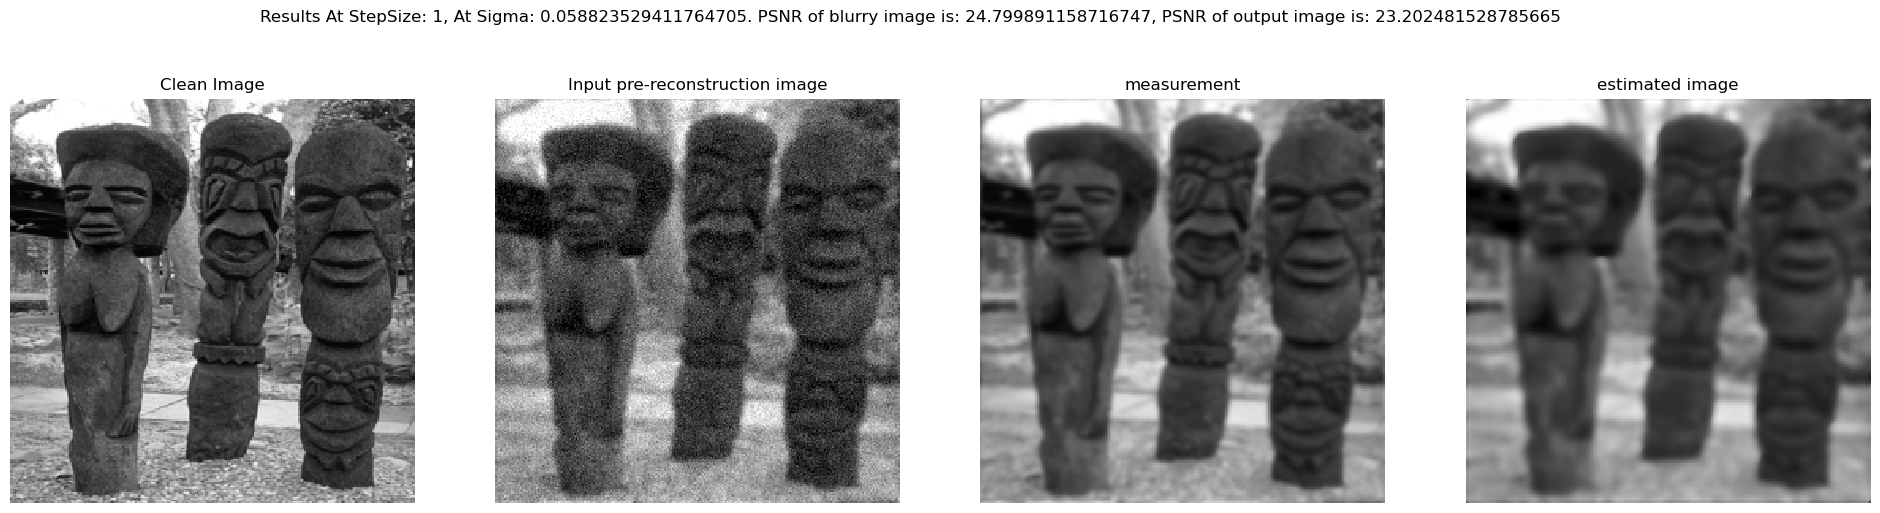

In [14]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {1}, At Sigma: {meas_sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 23.202481528785665


In [16]:
import scipy

In [17]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-4, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [18]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-6,2,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 39.41it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 38.27it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.83it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.85it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.64it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.61it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.64it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 38.31it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 38.03it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.82it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.77it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.69it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.60it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.60it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 37.45it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.66it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.55it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.63it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 39.33it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


 
 Func-count     x          f(x)          Procedure
    1       0.763933     -9.97176        initial


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 39.45it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 38.24it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.91it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.76it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 37.18it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.78it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.66it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.62it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.58it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.56it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.54it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.52it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.60it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.49it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.57it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.49it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.53it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.56it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 39.21it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    2        1.23607     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 39.58it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 38.25it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.10it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.23it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 38.19it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.97it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.35it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.88it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.74it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.69it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 38.25it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 38.14it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.92it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.79it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 37.47it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.74it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.67it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.62it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 39.36it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    3        1.52786     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 39.08it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 38.14it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.87it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.69it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.62it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.53it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.59it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.57it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 38.22it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 38.02it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.90it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.51it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.53it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.29it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.14it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.32it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.14it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.30it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 39.18it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    4         1.7082     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 36.43it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.36it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.04it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.52it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.44it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.01it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.61it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.64it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.03it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.24it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.81it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.49it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.17it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.77it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.50it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 36.95it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.01it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.05it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.88it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    5        1.81966     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.51it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.20it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.52it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.32it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.39it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.44it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.75it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.00it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 36.97it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.35it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 36.96it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.48it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 36.83it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.06it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.15it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.22it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 36.91it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.06it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.71it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    6        1.88854     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 37.92it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 36.74it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.07it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.24it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.98it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.22it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.26it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.27it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.38it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.37it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.39it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.44it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.48it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.46it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.42it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.42it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.50it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.50it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.90it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    7        1.93112     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 36.37it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.04it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 36.22it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 36.74it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 36.14it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 36.55it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.84it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.17it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 36.60it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 36.49it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:03<00:02, 36.75it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 36.84it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 36.96it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.19it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.29it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.42it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.38it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.44it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.51it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    8        1.95743     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 38.51it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.80it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.60it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.62it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.57it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.55it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.49it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.50it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 36.87it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.06it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.16it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.26it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.34it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.47it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.40it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.43it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.46it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.10it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.94it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


    9        1.97369     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.11it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.18it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.03it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.48it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 36.45it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 36.82it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.50it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 36.61it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 36.88it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 36.56it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:03<00:02, 36.66it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 36.36it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 36.77it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 36.32it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 36.67it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 36.76it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 36.31it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 36.21it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.20it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   10        1.98374     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.60it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 36.47it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 36.88it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 36.91it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 37.20it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 36.84it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.95it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.02it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.15it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 36.82it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.52it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 36.87it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 36.99it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.14it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.22it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.35it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.39it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.42it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.64it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   11        1.98995     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.04it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.05it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.27it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.35it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.36it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 36.64it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.75it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.26it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.26it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.31it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 36.75it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 36.89it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.06it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.25it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.33it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.34it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 36.78it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 36.46it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.52it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   12        1.99379     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 36.38it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 36.42it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 36.75it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 36.84it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 36.91it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 36.95it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.00it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.01it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.03it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.10it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:03<00:02, 37.09it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.08it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.11it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.08it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.11it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.14it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.05it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.09it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.57it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   13        1.99616     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.05it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.13it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.06it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.05it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 37.13it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.07it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.10it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.10it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.12it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.15it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.14it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.14it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.15it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.12it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.07it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.11it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.13it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.05it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.64it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   14        1.99763     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 38.57it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 36.68it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 36.93it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 37.12it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 37.41it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.39it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.81it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 36.90it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.01it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.20it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.36it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.34it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.35it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 36.74it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 36.93it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 36.87it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.29it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.36it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.64it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   15        1.99853     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 38.13it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.69it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 37.56it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 36.69it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 36.93it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.17it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 37.23it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 37.37it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 36.71it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.00it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.05it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 37.29it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 37.25it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 36.68it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 36.93it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.14it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 37.16it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 37.27it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.61it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   16        1.99909     -9.97176        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 28.226036071777344, PSNR of output is: 23.07903870030801, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:05, 37.40it/s]

At iter 10, loss is: 227.548828125, PSNR of output is: 18.929924878034022, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 36.26it/s]

At iter 20, loss is: 405.2099609375, PSNR of output is: 17.311545264806046, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 36.73it/s]

At iter 30, loss is: 589.0497436523438, PSNR of output is: 16.126714435396693, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:04, 36.93it/s]

At iter 40, loss is: 784.6982421875, PSNR of output is: 15.155091811607232, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:04, 37.22it/s]

At iter 50, loss is: 974.5924072265625, PSNR of output is: 14.388378694523503, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:03, 37.23it/s]

At iter 60, loss is: 1160.98876953125, PSNR of output is: 13.751548486471139, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:03, 36.66it/s]

At iter 70, loss is: 1348.7158203125, PSNR of output is: 13.193159275541682, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:02<00:03, 36.88it/s]

At iter 80, loss is: 1545.1253662109375, PSNR of output is: 12.67463837418224, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 37.08it/s]

At iter 90, loss is: 1760.585693359375, PSNR of output is: 12.166297521856945, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 37.17it/s]

At iter 100, loss is: 1970.8238525390625, PSNR of output is: 11.7230102688359, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:02, 37.27it/s]

At iter 110, loss is: 2165.404052734375, PSNR of output is: 11.352627913821415, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:03<00:02, 36.69it/s]

At iter 120, loss is: 2359.62109375, PSNR of output is: 11.014318801221606, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:03<00:01, 36.95it/s]

At iter 130, loss is: 2565.857421875, PSNR of output is: 10.68238645672107, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 37.06it/s]

At iter 140, loss is: 2756.8798828125, PSNR of output is: 10.396249456914745, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:04<00:01, 37.23it/s]

At iter 150, loss is: 2900.87353515625, PSNR of output is: 10.192475217402261, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:04<00:01, 37.28it/s]

At iter 160, loss is: 2995.156494140625, PSNR of output is: 10.064187669124331, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:04<00:00, 36.74it/s]

At iter 170, loss is: 3032.19287109375, PSNR of output is: 10.014529544691902, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:04<00:00, 36.92it/s]

At iter 180, loss is: 3046.656005859375, PSNR of output is: 9.99523752353428, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:05<00:00, 38.51it/s]

At iter 190, loss is: 3056.69091796875, PSNR of output is: 9.98189897596031, PSNR of input is: 24.799891158716747


   17        1.99944     -9.97176        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [19]:
def objFuncMapSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=300, sigmaNoiseMap = 0, meas_sigma=meas_sigma) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [20]:
bestMapSigma = scipy.optimize.fminbound(objFuncMapSigma,0,50/255,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.01it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.05it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 37.25it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.43it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.84it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 37.10it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.54it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.76it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.37it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.63it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.93it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.43it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.71it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.98it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.28it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.78it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.36it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.66it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.95it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.44it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.71it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.32it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.62it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.33it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.38it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.50it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.66it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.77it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.68it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


 
 Func-count     x          f(x)          Procedure
    1      0.0748953     0.497026        initial


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.05it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.22it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.89it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.95it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 37.03it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.93it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.03it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 37.46it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.50it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.97it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 37.01it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.62it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.51it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 37.01it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.44it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.73it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.36it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.50it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 37.13it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.55it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.88it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:02, 36.91it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 37.20it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.46it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.17it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.12it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.23it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.72it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.73it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    2       0.121183     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 36.94it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 35.91it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.54it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.21it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.55it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.29it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.63it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.78it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.91it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.45it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.77it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.31it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.65it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.23it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 35.72it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.44it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.11it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.57it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.85it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 37.04it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.50it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.80it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.96it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.62it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.63it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.29it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 35.96it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.61it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.51it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    3       0.149791     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 36.70it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.24it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 37.28it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.64it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.92it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.25it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.43it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.97it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 37.15it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.73it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.92it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.45it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.62it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.67it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 37.10it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 37.23it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.45it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.93it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.60it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.71it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.58it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.64it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.81it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.63it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.75it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.94it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 37.10it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.52it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.82it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    4       0.167471     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 36.51it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 36.48it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 35.96it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.33it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.58it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.94it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.59it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 37.20it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.91it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 37.14it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.64it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.95it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.57it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.89it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.48it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.56it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 37.13it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.65it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.86it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 37.18it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.68it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.97it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.52it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.89it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 37.11it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.63it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.71it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 37.20it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.83it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    5       0.178398     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:08, 35.62it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 36.75it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 37.15it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.37it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.95it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.47it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.85it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 37.10it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.58it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.91it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 37.13it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.66it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.96it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 37.16it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.67it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.94it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.51it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.85it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.91it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.71it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.99it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.55it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.87it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 37.10it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.63it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.65it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 37.23it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.71it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.82it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    6       0.185151     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 36.49it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.14it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.42it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 37.03it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 37.25it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.66it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 36.98it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 37.14it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.63it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.94it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.85it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.77it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 37.04it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.58it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.52it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 37.18it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.68it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.97it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.58it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.89it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 37.12it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.64it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.89it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 37.12it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.64it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.57it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.67it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.96it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.86it/s]


At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747
    7       0.189325     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 36.56it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.17it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.44it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 37.12it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.55it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.91it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.15it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.63it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.94it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.51it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.91it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 37.12it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.63it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.94it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 37.10it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.63it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.93it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.67it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.81it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 37.06it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.60it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:02, 36.89it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 37.12it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.64it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.94it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 37.14it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.65it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.95it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.88it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    8       0.191905     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.06it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 36.20it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.89it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 37.19it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.59it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.94it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.13it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.62it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.93it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.50it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.86it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 37.10it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.62it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.90it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 37.13it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.64it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.94it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 37.11it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.63it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.93it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 37.15it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:02, 36.70it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.98it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.54it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.62it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 37.14it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.65it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.95it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.88it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


    9       0.193499     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.06it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 37.39it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 37.08it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 37.30it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.66it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.83it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.23it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.69it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.98it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 37.14it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.64it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.94it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 37.16it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.71it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 36.99it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.55it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.87it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 37.06it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.60it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.91it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.55it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:02, 36.88it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 37.11it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.63it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.80it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 37.06it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.60it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.91it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.92it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


   10       0.194484     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.06it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 36.12it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.73it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:06, 37.09it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.53it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 37.04it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.24it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.69it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.99it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 37.03it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 36.57it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.89it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 36.63it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.93it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 37.15it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 36.66it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.76it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 37.02it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 37.21it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.70it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 36.55it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:05<00:02, 36.88it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 37.11it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 36.64it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 37.31it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 36.77it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 37.03it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.81it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.88it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


   11       0.195093     0.497026        golden


  0%|          | 0/300 [00:00<?, ?it/s]

At iter 0, loss is: 5.408203125, PSNR of output is: 23.418861176431275, PSNR of input is: 24.799891158716747


  4%|▎         | 11/300 [00:00<00:07, 37.06it/s]

At iter 10, loss is: 6.179861068725586, PSNR of output is: 20.841251445210442, PSNR of input is: 24.799891158716747


  7%|▋         | 21/300 [00:00<00:07, 36.34it/s]

At iter 20, loss is: 16.255931854248047, PSNR of output is: 15.248018975601065, PSNR of input is: 24.799891158716747


 10%|█         | 31/300 [00:00<00:07, 36.92it/s]

At iter 30, loss is: 44.729400634765625, PSNR of output is: 10.69621852871406, PSNR of input is: 24.799891158716747


 14%|█▎        | 41/300 [00:01<00:07, 36.38it/s]

At iter 40, loss is: 96.43415832519531, PSNR of output is: 7.420484309975502, PSNR of input is: 24.799891158716747


 17%|█▋        | 51/300 [00:01<00:06, 36.40it/s]

At iter 50, loss is: 160.9554443359375, PSNR of output is: 5.209644336084032, PSNR of input is: 24.799891158716747


 20%|██        | 61/300 [00:01<00:06, 36.83it/s]

At iter 60, loss is: 227.19403076171875, PSNR of output is: 3.5979679872838193, PSNR of input is: 24.799891158716747


 24%|██▎       | 71/300 [00:01<00:06, 37.10it/s]

At iter 70, loss is: 296.01434326171875, PSNR of output is: 2.3506751354287143, PSNR of input is: 24.799891158716747


 27%|██▋       | 81/300 [00:02<00:05, 36.60it/s]

At iter 80, loss is: 356.843017578125, PSNR of output is: 1.3904181961033146, PSNR of input is: 24.799891158716747


 30%|███       | 91/300 [00:02<00:05, 36.90it/s]

At iter 90, loss is: 400.23614501953125, PSNR of output is: 0.7743255346129602, PSNR of input is: 24.799891158716747


 34%|███▎      | 101/300 [00:02<00:05, 36.80it/s]

At iter 100, loss is: 432.63555908203125, PSNR of output is: 0.3552540010413514, PSNR of input is: 24.799891158716747


 37%|███▋      | 111/300 [00:03<00:05, 37.06it/s]

At iter 110, loss is: 452.889404296875, PSNR of output is: 0.10151706036265493, PSNR of input is: 24.799891158716747


 40%|████      | 121/300 [00:03<00:04, 36.59it/s]

At iter 120, loss is: 463.6038818359375, PSNR of output is: -0.0494255378814108, PSNR of input is: 24.799891158716747


 44%|████▎     | 131/300 [00:03<00:04, 37.25it/s]

At iter 130, loss is: 468.6610412597656, PSNR of output is: -0.1351477826896954, PSNR of input is: 24.799891158716747


 47%|████▋     | 141/300 [00:03<00:04, 36.72it/s]

At iter 140, loss is: 470.79949951171875, PSNR of output is: -0.19393088259907515, PSNR of input is: 24.799891158716747


 50%|█████     | 151/300 [00:04<00:04, 37.00it/s]

At iter 150, loss is: 474.32379150390625, PSNR of output is: -0.24972639717677986, PSNR of input is: 24.799891158716747


 54%|█████▎    | 161/300 [00:04<00:03, 37.20it/s]

At iter 160, loss is: 476.9566650390625, PSNR of output is: -0.2956386009116583, PSNR of input is: 24.799891158716747


 57%|█████▋    | 171/300 [00:04<00:03, 36.95it/s]

At iter 170, loss is: 480.80859375, PSNR of output is: -0.33603309737444365, PSNR of input is: 24.799891158716747


 60%|██████    | 181/300 [00:04<00:03, 36.52it/s]

At iter 180, loss is: 480.6036376953125, PSNR of output is: -0.3578522504946096, PSNR of input is: 24.799891158716747


 64%|██████▎   | 191/300 [00:05<00:02, 36.85it/s]

At iter 190, loss is: 480.74847412109375, PSNR of output is: -0.373634785504409, PSNR of input is: 24.799891158716747


 67%|██████▋   | 201/300 [00:05<00:02, 36.87it/s]

At iter 200, loss is: 483.65557861328125, PSNR of output is: -0.3987475343929365, PSNR of input is: 24.799891158716747


 70%|███████   | 211/300 [00:05<00:02, 37.11it/s]

At iter 210, loss is: 483.6506042480469, PSNR of output is: -0.414550075649194, PSNR of input is: 24.799891158716747


 74%|███████▎  | 221/300 [00:06<00:02, 36.63it/s]

At iter 220, loss is: 478.874755859375, PSNR of output is: -0.41086918619938123, PSNR of input is: 24.799891158716747


 77%|███████▋  | 231/300 [00:06<00:01, 36.93it/s]

At iter 230, loss is: 479.54425048828125, PSNR of output is: -0.4221457268939708, PSNR of input is: 24.799891158716747


 80%|████████  | 241/300 [00:06<00:01, 37.09it/s]

At iter 240, loss is: 477.81982421875, PSNR of output is: -0.4324107520457817, PSNR of input is: 24.799891158716747


 84%|████████▎ | 251/300 [00:06<00:01, 36.83it/s]

At iter 250, loss is: 476.78253173828125, PSNR of output is: -0.4461254496396844, PSNR of input is: 24.799891158716747


 87%|████████▋ | 261/300 [00:07<00:01, 37.08it/s]

At iter 260, loss is: 478.69232177734375, PSNR of output is: -0.45744837954798717, PSNR of input is: 24.799891158716747


 90%|█████████ | 271/300 [00:07<00:00, 36.61it/s]

At iter 270, loss is: 478.2271728515625, PSNR of output is: -0.4661779914069389, PSNR of input is: 24.799891158716747


 94%|█████████▎| 281/300 [00:07<00:00, 36.73it/s]

At iter 280, loss is: 478.38189697265625, PSNR of output is: -0.47352233385609394, PSNR of input is: 24.799891158716747


100%|██████████| 300/300 [00:07<00:00, 37.85it/s]

At iter 290, loss is: 477.7696533203125, PSNR of output is: -0.48360543509961246, PSNR of input is: 24.799891158716747


   12       0.195469     0.497026        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [21]:
print(bestMapSigma)

0.19546948627154082


In [22]:
print(bestStepsize)

1.9994399331158883


In [23]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = bestMapSigma, 
                         meas_sigma = 15/255
                    )

  0%|          | 0/500 [00:00<?, ?it/s]

At iter 0, loss is: 14.904711723327637, PSNR of output is: 23.892184504190798, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:13, 37.40it/s]

At iter 10, loss is: 14.86351203918457, PSNR of output is: 23.776069190736663, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:12, 37.10it/s]

At iter 20, loss is: 15.016387939453125, PSNR of output is: 23.77132291308719, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:12, 36.38it/s]

At iter 30, loss is: 15.305787086486816, PSNR of output is: 23.762094920771656, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:01<00:12, 36.69it/s]

At iter 40, loss is: 15.865974426269531, PSNR of output is: 23.744076722527062, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:12, 37.04it/s]

At iter 50, loss is: 17.14137077331543, PSNR of output is: 23.70350367554197, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:12, 36.48it/s]

At iter 60, loss is: 20.11923599243164, PSNR of output is: 23.61058717500648, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:11, 36.76it/s]

At iter 70, loss is: 25.684436798095703, PSNR of output is: 23.442713797119143, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:02<00:11, 36.22it/s]

At iter 80, loss is: 33.37433624267578, PSNR of output is: 23.2214782712786, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:11, 36.68it/s]

At iter 90, loss is: 42.08013153076172, PSNR of output is: 22.98406188686262, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:10, 36.93it/s]

At iter 100, loss is: 50.32424545288086, PSNR of output is: 22.770670526846995, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:03<00:10, 36.45it/s]

At iter 110, loss is: 57.38693618774414, PSNR of output is: 22.59582551792438, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:03<00:10, 36.76it/s]

At iter 120, loss is: 63.3343391418457, PSNR of output is: 22.45391608305786, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:03<00:10, 36.26it/s]

At iter 130, loss is: 67.94656372070312, PSNR of output is: 22.347229197227744, PSNR of input is: 24.799891158716747


 28%|██▊       | 141/500 [00:03<00:09, 36.03it/s]

At iter 140, loss is: 71.49078369140625, PSNR of output is: 22.26706182565796, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:04<00:09, 36.07it/s]

At iter 150, loss is: 74.3001708984375, PSNR of output is: 22.204574914491047, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:04<00:09, 36.80it/s]

At iter 160, loss is: 76.58939361572266, PSNR of output is: 22.154305976954344, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:04<00:09, 36.35it/s]

At iter 170, loss is: 78.49015808105469, PSNR of output is: 22.11302390086442, PSNR of input is: 24.799891158716747


 36%|███▌      | 181/500 [00:04<00:08, 35.65it/s]

At iter 180, loss is: 80.2075424194336, PSNR of output is: 22.07596639682513, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:05<00:08, 35.70it/s]

At iter 190, loss is: 81.99409484863281, PSNR of output is: 22.03778175056852, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:05<00:08, 35.94it/s]

At iter 200, loss is: 83.65895080566406, PSNR of output is: 22.002607451718674, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:05<00:07, 36.17it/s]

At iter 210, loss is: 85.16920471191406, PSNR of output is: 21.9709428964996, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:06<00:07, 36.03it/s]

At iter 220, loss is: 86.61132049560547, PSNR of output is: 21.94086557647427, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:06<00:07, 36.42it/s]

At iter 230, loss is: 88.0779037475586, PSNR of output is: 21.91043213240996, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:06<00:07, 36.07it/s]

At iter 240, loss is: 89.64900207519531, PSNR of output is: 21.87801531527711, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:06<00:06, 35.61it/s]

At iter 250, loss is: 91.38829040527344, PSNR of output is: 21.842381362269872, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:07<00:06, 35.74it/s]

At iter 260, loss is: 93.34725952148438, PSNR of output is: 21.802588428021807, PSNR of input is: 24.799891158716747


 54%|█████▍    | 271/500 [00:07<00:06, 35.61it/s]

At iter 270, loss is: 95.55500793457031, PSNR of output is: 21.758177446118808, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:07<00:06, 36.17it/s]

At iter 280, loss is: 98.01201629638672, PSNR of output is: 21.70930681801344, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:08<00:05, 35.70it/s]

At iter 290, loss is: 100.71995544433594, PSNR of output is: 21.656091596951477, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:08<00:05, 36.03it/s]

At iter 300, loss is: 103.67591857910156, PSNR of output is: 21.598747501760673, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:08<00:05, 36.86it/s]

At iter 310, loss is: 106.90650177001953, PSNR of output is: 21.53697036210254, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:08<00:04, 36.39it/s]

At iter 320, loss is: 110.47805786132812, PSNR of output is: 21.46968895517304, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:09<00:04, 36.04it/s]

At iter 330, loss is: 114.48291015625, PSNR of output is: 21.39545497694241, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:09<00:04, 35.82it/s]

At iter 340, loss is: 118.9666748046875, PSNR of output is: 21.31379399603361, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:09<00:04, 35.70it/s]

At iter 350, loss is: 123.66726684570312, PSNR of output is: 21.22978699765277, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:09<00:03, 35.87it/s]

At iter 360, loss is: 128.06869506835938, PSNR of output is: 21.152589182673452, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:10<00:03, 36.19it/s]

At iter 370, loss is: 132.01902770996094, PSNR of output is: 21.08447806391905, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:10<00:03, 36.48it/s]

At iter 380, loss is: 135.45944213867188, PSNR of output is: 21.026045903457124, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:10<00:02, 36.84it/s]

At iter 390, loss is: 138.35963439941406, PSNR of output is: 20.97740822042843, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:11<00:02, 37.03it/s]

At iter 400, loss is: 140.75958251953125, PSNR of output is: 20.937574574197043, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:11<00:02, 37.13it/s]

At iter 410, loss is: 142.72964477539062, PSNR of output is: 20.905149684152494, PSNR of input is: 24.799891158716747


 84%|████████▍ | 421/500 [00:11<00:02, 36.63it/s]

At iter 420, loss is: 144.35736083984375, PSNR of output is: 20.878540256946152, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:11<00:01, 36.86it/s]

At iter 430, loss is: 145.708984375, PSNR of output is: 20.856567808392494, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:12<00:01, 37.03it/s]

At iter 440, loss is: 146.83761596679688, PSNR of output is: 20.83830463214686, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:12<00:01, 37.18it/s]

At iter 450, loss is: 147.7866973876953, PSNR of output is: 20.823003078847183, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:12<00:01, 36.64it/s]

At iter 460, loss is: 148.59124755859375, PSNR of output is: 20.810071436259186, PSNR of input is: 24.799891158716747


 94%|█████████▍| 471/500 [00:12<00:00, 36.85it/s]

At iter 470, loss is: 149.27622985839844, PSNR of output is: 20.799089434949735, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:13<00:00, 37.07it/s]

At iter 480, loss is: 149.86033630371094, PSNR of output is: 20.789744194784237, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:13<00:00, 37.00it/s]

At iter 490, loss is: 150.35894775390625, PSNR of output is: 20.7817793201917, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

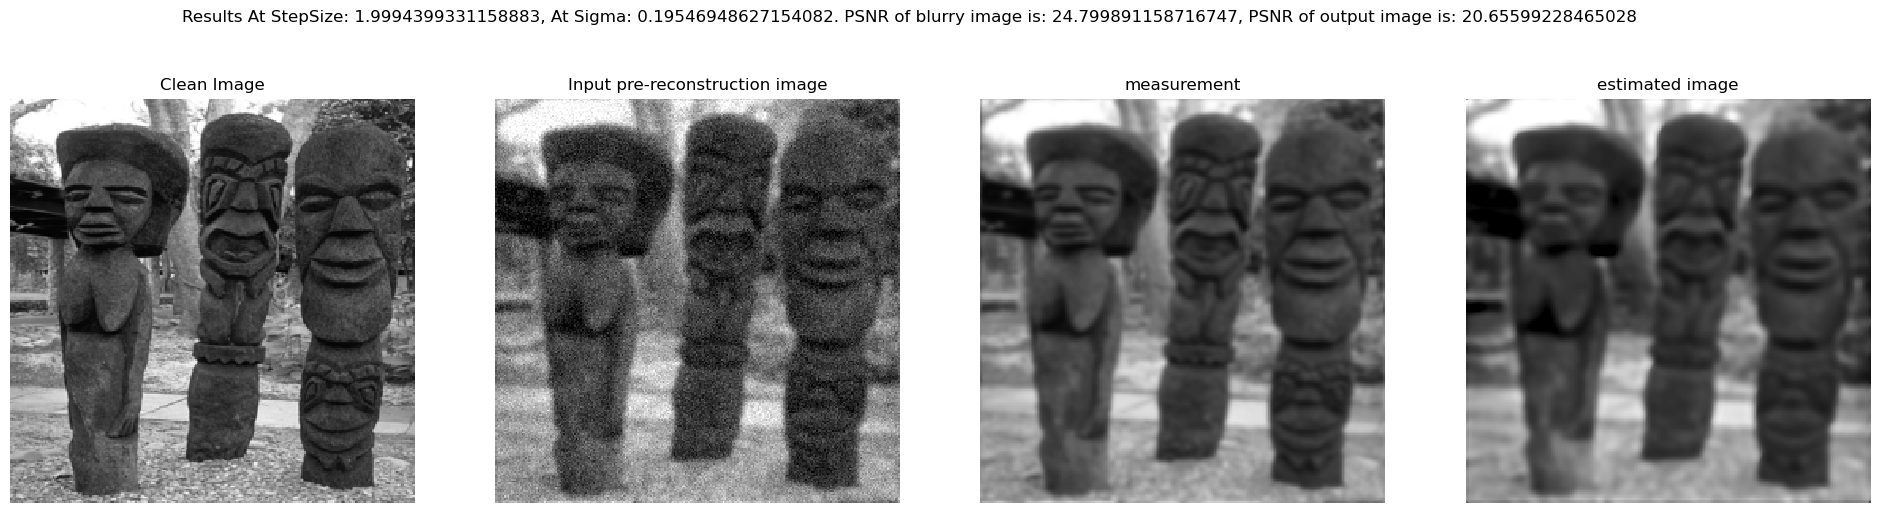

In [24]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {bestMapSigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')